<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

## <center>Домашнее задание №8</center>
## <center>Xgboost и данные Samsung по типу активности людей</center>

In [27]:
import numpy as np
import pandas as pd
%pylab inline
figsize(8,6)
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


**Считываем [данные](https://yadi.sk/d/ha-lprkDvozGx) Samsung Human Activity Recognition. Почитайте [описание](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) эксперимента. Вкратце: задача – прогнозировать тип активности человека (ходьба, ходьба вверх по лестнице, вниз по лестнице, сидение, стояние и лежание) по данным с акселерометра и гироскопа его смартфона (Samsung Galaxy S3). **

In [28]:
# поменяйте пути к файлам
X_train = np.loadtxt(
    '../../data/samsung_train.txt')
y_train = np.loadtxt(
    '../../data/samsung_train_labels.txt').astype(int)
X_test = np.loadtxt(
    '../../data/samsung_test.txt')
y_test = np.loadtxt(
    '../../data/samsung_test_labels.txt').astype(int)

In [29]:
X_train.shape, X_test.shape

((7352, 561), (2947, 561))

**Видим, что распределение классов (типов активностей) довольно равномерно.**

In [30]:
np.bincount(y_train), np.bincount(y_test)

(array([   0, 1226, 1073,  986, 1286, 1374, 1407], dtype=int64),
 array([  0, 496, 471, 420, 491, 532, 537], dtype=int64))

**Выделим столько главных компонент, чтоб осталось 90% дисперсии исходных данных.**

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_test_pca = pca.transform(scaler.transform(X_test))
print(X_test_pca.shape)

(7352, 63)
(2947, 63)


**Видим, что изначально был 561 признак, но мы оставили 63. Бросим взгляд на обучающую выборку – отобразим ее в проекции на первые 2 главные компоненты.**

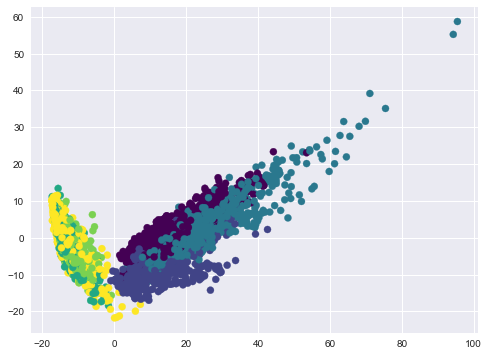

In [32]:
scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=50, cmap='viridis');

**Видим, что отчетливо выделяются 2 группы активности – ходьба (в том числе вверх и вниз) и все остальное.**

**Зафиксируем объект StratifiedKFold, с его помощью будет проводить кросс-валидацию.**

In [33]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Используйте sklearn-обертку Xgboost для оценки доли правильных ответов на кросс-валидации с данными (X_train_pca, y_train). Укажите параметр XGBClassifier seed=7 (это то же по сути, что random_state), остальные оставьте по умолчанию. Используйте ранее созданный объект StratifiedKFold.**

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [35]:
xgb_model1 = XGBClassifier(seed=7)
results = cross_val_score(xgb_model1, X_train_pca, y_train, cv=skf, scoring='accuracy')

**<font color='red'>Вопрос 1.</font> Какова средняя доля правильных ответов Xgboost на кросс-валидации? Округлите до 3 знаков после разделителя.**

In [36]:
results.mean()

0.92315441220896555

**Сделайте все то же для случайного леса из 100 деревьев, параметр random_state укажите равным 7.**

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
forest = RandomForestClassifier(random_state=7, n_estimators=100)
results2 = cross_val_score(forest, X_train_pca, y_train, cv=skf, scoring='accuracy')

**<font color='red'>Вопрос 2.</font> Какова средняя доля правильных ответов случайного леса на кросс-валидации? Округлите до 3 знаков после разделителя.**

In [39]:
results2.mean()

0.92437434915963845

**Постройте кривые валидации по глубине деревьев для Xgboost. Все прочие параметры кросс-валидации возьмите как на предыдущем шаге. Достаточно сохранять только среднюю долю правильных ответов на валидационной части (на обучающей – не обязательно).**

In [40]:
tree_depths = [6, 9, 12, 15]
xgb_scores = []
for depth in tree_depths:
    xgb_model1 = XGBClassifier(seed=7, max_depth=depth)
    results = cross_val_score(xgb_model1, X_train_pca, y_train, cv=skf, scoring='accuracy')
    xgb_scores.append(results.mean())

In [42]:
%%time
from sklearn.model_selection import validation_curve
xgb_model1 = XGBClassifier(seed=7)
val_train, val_test = validation_curve(xgb_model1, X_train_pca, y_train,
                                       cv=skf, param_name= 'max_depth', param_range=tree_depths,
                                       scoring='accuracy')

Wall time: 4min 7s


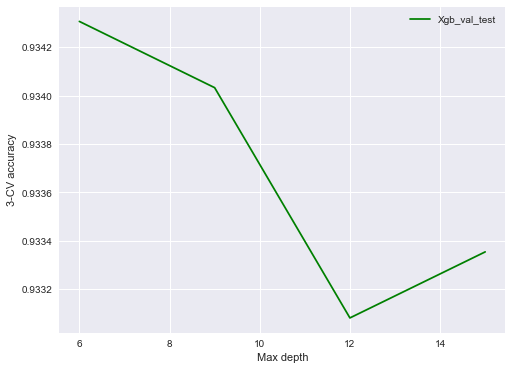

In [57]:
plot(tree_depths, val_test.mean(axis=1), color='green', label='Xgb_val_test');
xlabel('Max depth')
ylabel('3-CV accuracy')
legend();

**Используйте RandomizedGridSearch, чтобы настроить параметры бустинга. Задайте 10 итераций (будут перебираться случайные 10 комбинаций параметров), а кросс-валидацию – как ранее. Не забудьте про random_state=7. Выведите лучшие параметры и accuracy (поля best\_params\_ и best\_score\_ у обученного RandomizedGridSearch).**

In [58]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
xgb_params_dist_grid = {
    'max_depth': np.arange(10,14),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': [0.5, 0.75, 1.],
    'colsample_bytree': [0.5, 0.75, 1.]
}
xgb_params_fixed = {
    'n_estimators': 10,
    'silent': 1,
    'seed': 7
}

In [60]:
xgb = XGBClassifier(n_estimators=10, silent=1, seed=7)
xgb_grid = RandomizedSearchCV(xgb, random_state=7, n_iter=10, cv=skf, 
                              param_distributions=xgb_params_dist_grid)

In [83]:
%%time
xgb_grid.fit(X_train_scaled, y_train);

Wall time: 7min 24s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=1, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': array([10, 11, 12, 13]), 'gamma': array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ]), 'subsample': [0.5, 0.75, 1.0], 'colsample_bytree': [0.5, 0.75, 1.0]},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [87]:
cross_val_score(xgb_grid, X_train_pca, y_train, cv=skf, scoring='accuracy').mean()

KeyboardInterrupt: 

**<font color='red'>Вопрос 3.</font> Каково лучшее (из перебранных) значение средней доли правильных ответов Xgboost на кросс-валидации? Округлите до 3 знаков после разделителя.**

In [ ]:
xgb_grid.best_params_, xgb_grid.best_score_

**Проверьте доли правильных ответов настроенного и изначального бустинга на оставленной выборке.**

In [64]:
xgb_model2 = XGBClassifier(n_estimators=10, silent=1, seed=7, colsample_bytree=0.5, gamma=0.25, max_depth=12, subsample=1.0)

In [65]:
xgb_model2.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0.25, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=1, subsample=1.0)

In [67]:
xgb_model1.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)

**<font color='red'>Вопрос 4.</font> Каковы доли правильных ответов Xgboost на отложенной выборке до настройки параметров и после нее? Округлите до 3 знаков после разделителя.**

In [68]:
accuracy_score(y_test, xgb_model1.predict(X_test_pca))

0.88564642008822536

In [66]:
accuracy_score(y_test, xgb_model2.predict(X_test_pca))

0.86189345096708514

**Наконец, подберем число итераций бустинга. Общее правило: чем меньше темп обучения (learning_rate) и больше итераций (деревьев), тем точнее будет найден минимум функции ошибки и, соответственно, выше будет качество классификации. Но, естественно, тем дольше бустинг будет обучаться. Укажем learning_rate=0.03 (остальные параметры возьмем те же, что нашел *RandomizedGridSearchCV*) и построим кривые валидации Xgboost по числу итераций (до 300) с помощью функции cv из xgboost.**

In [69]:
from xgboost import cv, DMatrix

In [70]:
# каприз Xgboost: надо чтоб метки были от 0 до n_classes-1
y_train -= 1
y_test -= 1

In [71]:
dtrain = DMatrix(X_train_pca, y_train)

In [72]:
best_xgb_params = {'colsample_bytree': 0.75, 'gamma': 0.25, 
                   'max_depth': 11, 'subsample': 1.0,
                    'silent': 1, 'learning_rate': 0.03,
                   'eval_metric': 'merror',
                   'num_class': 6,
                    'seed': 7}

In [73]:
%%time
cv_result = cv(best_xgb_params, dtrain, 
                      num_boost_round=300,  
                      nfold=5)

Wall time: 5min 58s


In [74]:
cv_result.head()

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.165850,0.008281,0.034218,0.002423
1,0.125442,0.005350,0.015918,0.001564
2,0.108027,0.006270,0.011769,0.001094
3,0.102585,0.004521,0.009150,0.000709
4,0.096871,0.005986,0.007823,0.000372


In [75]:
def plot_with_err(index, means, stds=None, **kwargs):
    lines = plt.plot(index, means, '-', **kwargs)
    plt.fill_between(index, means - stds, means + stds, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

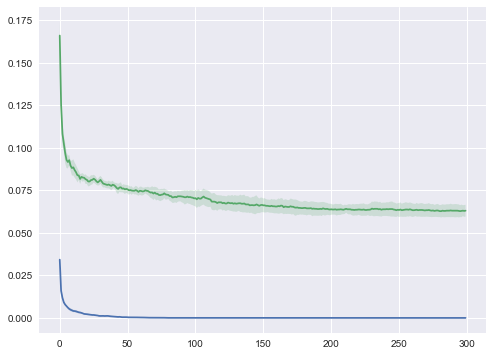

In [76]:
plot_with_err(cv_result.index, cv_result['train-merror-mean'], 
              cv_result['train-merror-std']);
plot_with_err(cv_result.index, cv_result['test-merror-mean'], 
              cv_result['test-merror-std']);

**Проверьте долю правильных ответов последней версии бустинга (с 300 итерациями) на оставленной выборке. Используйте функцию train из xgboost. X_test также надо будет переделать в DMatrix, только ответы y_test туда уже не передавайте.**

In [78]:
from xgboost import train

In [79]:
dtest = DMatrix(X_test_pca)

In [95]:
final_xgb = train(best_xgb_params, dtrain, num_boost_round=300)

In [97]:
y_pred = final_xgb.predict(dtest)

**<font color='red'>Вопрос 5.</font> Какова доля правильных ответов Xgboost с большим числом итераций и малым шагом на отложенной выборке? Округлите до 3 знаков после разделителя.**

In [98]:
accuracy_score(y_pred, y_test)

0.89107567017305733